In [1]:
# General dependencies
import os, shutil
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from glob import glob

import mne
import mne_nirs

In [2]:
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../..')
from preprocessing.scripts import argParser
from preprocessing.src import Plots

In [4]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/CARE/NIRS_data_unclean"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

In [5]:
session_dirs = [d for d in glob(study_dir+"/*/V*/*fNIRS") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [6]:
mne.viz.set_3d_backend('pyvista')
raw_intensities = []

for ses in session_dirs:
    
    if os.path.basename(ses)[:participant_num_len] == "50600":
        pass
    else:
        continue
    
    evts = glob(ses + "/*.evt")
    if len(evts) != 2:
        print("There should be 2 evt files. Skipping:", os.path.basename(ses))
        continue
    
    raw_intensities.append(mne.io.read_raw_nirx(ses).load_data())
#     raw_intensities[-1].resample(0.7) # downsample to 0.7 HZ to run faster
    
#     # replace raw_ints annotations with events from custom file. 
#     # read events from file
#     events, event_dict = mne.read_events(join(ses, "new_eve.txt"))
#     annot_from_events = mne.annotations_from_events(
#         events=events,
#         event_desc=event_dict,
#         sfreq=raw_intensities[-1].info['sfreq'],
#         orig_time=raw_intensities[-1].info['meas_date'])
    
#     raw_intensities[-1].set_annotations(annot_from_events)

Using pyvistaqt 3d backend.

Loading /data/perlman/moochie/analysis/CARE/NIRS_data_unclean/50601/V0/50600_V0_fNIRS
Reading 0 ... 13998  =      0.000 ...  1791.744 secs...


</usr/local/lib/python3.7/dist-packages/decorator.py:decorator-gen-225>:12: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.


In [7]:
raw_intensities[0]

<RawNIRX | 50600_V0_fNIRS, 20 x 13999 (1791.7 s), ~2.2 MB, data loaded>

In [9]:
len(raw_intensities[0])

13999

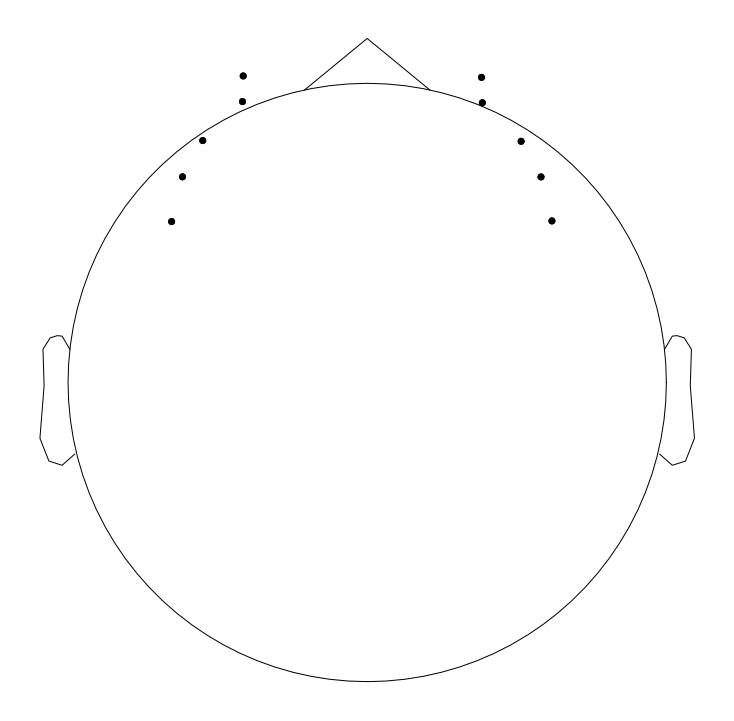

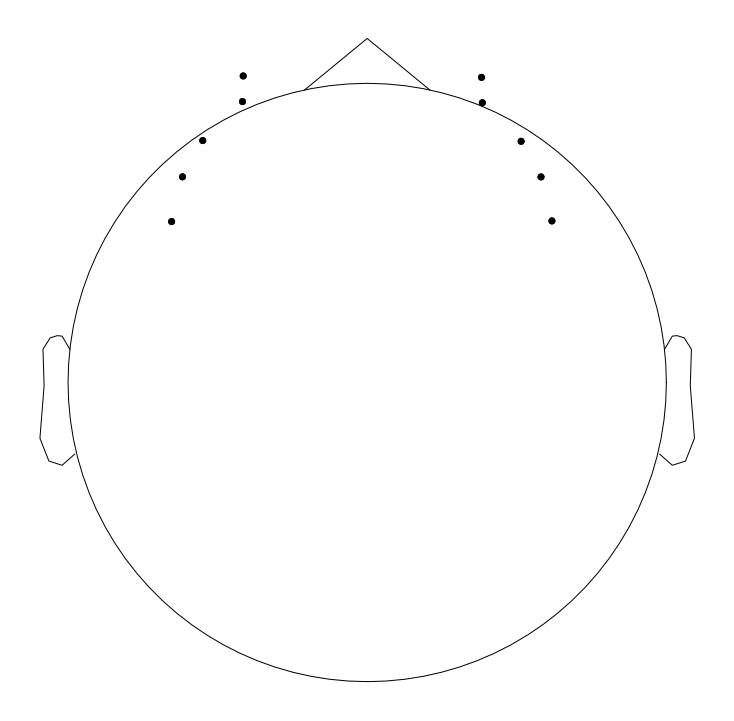

In [30]:
raw_intensities[0].plot_sensors() # viz is screwed up lol

In [47]:
fig = mne.viz.create_3d_figure(size=(800, 600), bgcolor='white')

fig = mne.viz.plot_alignment(
    raw_intensities[0].info,
    show_axes=True,
    subject='fsaverage',
    coord_frame='mri',
    trans='fsaverage',
    surfaces=['brain'],
    fnirs=[
        'channels',
        'pairs',
        'sources',
        'detectors'],
    subjects_dir="/usr/local/pkg/freesurfer/subjects",
    fig=fig)

Channel types::	fnirs_cw_amplitude: 20


In [50]:
b = mne.viz.Brain(
    'fsaverage',
    'both',
    'pial',
    subjects_dir="/usr/local/pkg/freesurfer/subjects",
    figure=fig,
    units='m',
    alpha=0.2,
    cortex='low_contrast')

labels = mne.read_labels_from_annot(
    'fsaverage', 
    subjects_dir="/usr/local/pkg/freesurfer/subjects")

ROIs = [
    'frontalpole-lh',
    'frontalpole-rh',
    'temporalpole-lh',
    'temporalpole-rh'
]

colors = [
    'green',
    'blue',
    'red',
    'orange',
    'yellow'
]

aud_labels = [label for label in labels if label.name in ROIs]
for i, label in enumerate(aud_labels):
    b.add_label(label, borders=False, color=colors[len(colors)%(i+1)])

Reading labels from parcellation...
   read 35 labels from /usr/local/pkg/freesurfer/subjects/fsaverage/label/lh.aparc.annot
   read 34 labels from /usr/local/pkg/freesurfer/subjects/fsaverage/label/rh.aparc.annot


In [51]:
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (
    get_long_channels,
    get_short_channels,
    picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix

# Clean up annotations before analysis

Next we update the annotations by assigning names to each trigger ID. Then we crop the recording to the section containing our experimental conditions.

In [75]:
durations = {
    'Block 1 Start': 120,
    'Block 2 Start': 105,
    'Block 3 Start': 120,
    'Stop Signal': 1}

In [76]:
for raw_ints in raw_intensities:
    print(raw_ints)
    print(raw_ints.annotations)
    
    raw_ints.annotations.rename({
        '1.0': 'Block 1 Start',
        '2.0': 'Block 2 Start',
        '4.0': 'Block 3 Start',
        '128.0': 'Stop Signal'})

<RawNIRX | 50502_V0_fNIRS, 20 x 14351 (1836.8 s), ~2.2 MB, data loaded>
<Annotations | 24 segments: Block 1 Start (4), Block 2 Start (4), Block 3 ...>


ValueError: Invalid Annotation description(s) {'1.0', '2.0', '4.0', '128.0'} are not present in data

In [ ]:
for raw_ints in raw_intensities:
    raw_ints.annotations.set_durations(durations, verbose=True)

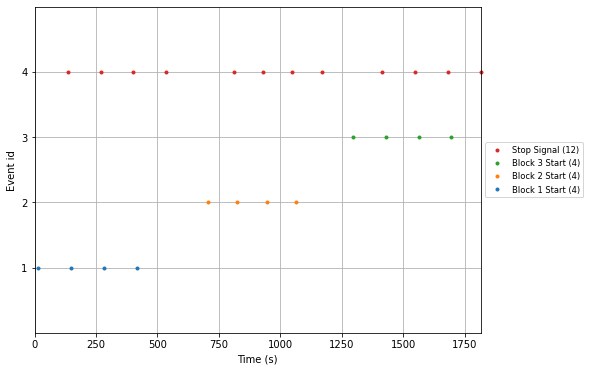

In [77]:
for raw_ints in raw_intensities:
    events, event_dict = mne.events_from_annotations(
        raw_ints,
        verbose=False)

    mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_ints.info['sfreq'])

In [78]:
print(event_dict)

{'Block 1 Start': 1, 'Block 2 Start': 2, 'Block 3 Start': 3, 'Stop Signal': 4}


In [81]:
def create_boxcar(raw, event_id=None, stim_dur=1):
    """
    Generate boxcar representation of the experimental paradigm.

    Parameters
    ----------
    raw : instance of Raw
        Haemoglobin data.
    event_id : as specified in MNE
        Information about events.
    stim_dur : Number
        The length of your stimulus.

    Returns
    -------
    s : array
        Returns an array for each annotation label.
    """
    from scipy import signal
    
    events, ids = mne.events_from_annotations(raw, event_id=event_id)
    s = np.zeros((len(raw.times), len(ids)))
    for idx, id in enumerate(ids):
        bc = signal.boxcar(round(raw.info['sfreq'] * stim_dur[id]))
        
        id_idx = [e[2] == idx + 1 for e in events]
        id_evt = events[id_idx]
        event_samples = [e[0] for e in id_evt]
        s[event_samples, idx] = 1.
        s[:, idx] = np.convolve(s[:, idx], bc)[:len(raw.times)]
    return s

Used Annotations descriptions: ['Block 1 Start', 'Block 2 Start', 'Block 3 Start', 'Stop Signal']


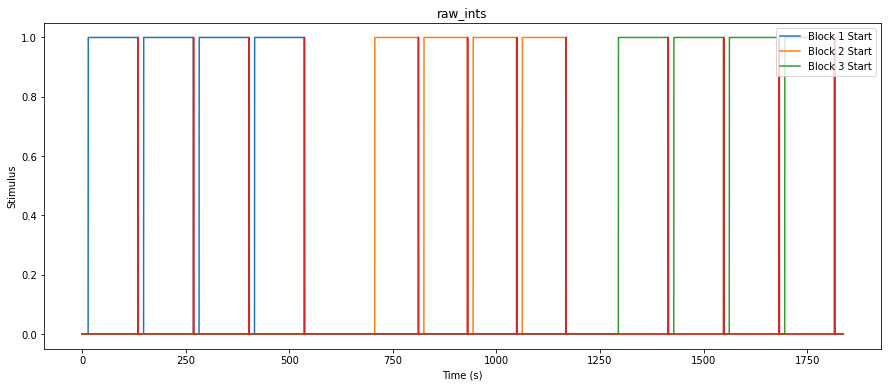

In [103]:
for raw_ints in raw_intensities:
    s = create_boxcar(
        raw_ints,
        stim_dur = durations)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
    plt.plot(raw_ints.times, s, axes=axes)
    plt.legend([
        "Block 1 Start",
        "Block 2 Start",
        "Block 3 Start"],
        loc="upper right")
    plt.xlabel("Time (s)")
    plt.ylabel("Stimulus")
    plt.title("raw_ints")
#     plt.xlim(0, 1800)

In [100]:
raw_ints.info['subject_info']['his_id']

'5050'

# Preprocess NIRS Data

In [35]:
raw_ods = []
for raw_ints in raw_intensities:
    raw_od = mne.preprocessing.nirs.optical_density(raw_ints)
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)
    
    #short_chs = get_short_channels(raw_haemo)
    long_chs = get_long_channels(raw_haemo)

In [101]:
len(raw_ints)

14351

In [36]:
long_chs

<RawNIRX | 50771_V0_fNIRS, 16 x 1362 (1944.3 s), ~197 kB, data loaded>

# Create design matrix

In [37]:
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    hrf_model='spm',
    stim_dur=5.0,
    drift_order=3,
    drift_model='polynomial')

ValueError: At least one regressor name can't be used as a column identifier: ['10']